# Code for fitting Astero RC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 
import pandas as pd
import pystan

import os
import pickle

import sys

In [2]:
def read_data():
    sfile = '../data/KepxDR2/rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [3]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 7497


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,BC_GBP,BC_GRP,BC_J,BC_H,BC_K,ast_MKs,ast_MH,ast_MJ,ast_MG,ast_M_err
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,-0.740,0.388,1.206,1.638,1.766,-1.671046,-1.543046,-1.111046,0.343954,0.206767
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,-0.754,0.409,1.252,1.706,1.840,-1.878376,-1.744376,-1.290376,0.205624,0.166498


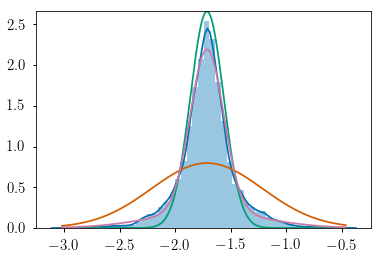

-1.7155484516776585


In [4]:
'''Step one is figuring out the different distributions we want'''
df.head(2)
Ks = df.ast_MKs.values

x = np.linspace(Ks.min(),Ks.max(),1000)

fg = normal(x, np.median(Ks), 0.15)
bg = normal(x, np.median(Ks), .5)
Q = .75
pp = Q*fg + (1-Q)*bg

sns.distplot(Ks)
plt.plot(x,fg)
plt.plot(x,bg)
plt.plot(x,pp)
plt.show()

print(np.median(Ks))

## Stan model for asteroseismic values

In [14]:
overwrite = True
asterostan = '''
data {
    int<lower = 0> N;
    real M[N];
    real <lower=0> M_err[N];
}

parameters {
    //Hyperparameters
    real mu;
//    real tmuo;
    real <lower=0.> sigma;
    real <lower=0.3> sigo;
    real <lower=0.,upper=1.> Q;
    
    //Latent Parameters
    real M_infd_std[N];
}
transformed parameters{
    //'True' parameters
    real M_infd[N];
    
    //Inferred and transformed parameters
//    real tmuo;
    real tsigo;
    
    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma*M_infd_std[n];
    }
//    tmuo = muo - mu;
    tsigo = sigo / sigma;
}
model {
    //Observables
    M ~ normal(M_infd, M_err); //Measurement uncertainty
    
    //Hyperparameters in true space
//    mu ~ normal(-1.71, .1);
//    sigma ~ normal(.1, .05);
//    Q ~ normal(1., .01);
//    muo ~ normal(-1.71, .01);
//    sigo ~ normal(1., .1);

    mu ~  uniform(-1.9, -1.5);
    sigma ~ uniform(0., .3);
    Q ~ uniform(.9, 1.);
//    muo ~  uniform(-1.9, -1.5);
    sigo ~ uniform(.3, 3.);    
    
//    tmuo ~ uniform(0., .1);

    //Mixture model (in transformed space)
    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0, tsigo));
}
'''
model_path = 'asterostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL asterostan_d79aa939a205bdcd6531e89dfb78632e NOW.


Updating Stan model


In [15]:
sel = df[:1000]
M = sel.ast_MKs.values
M_err = sel.ast_M_err.values
m = sel.kmag
dat = {'N': len(sel),
      'M': M,
      'M_err' : M_err}

init = {'mu':-1.71,
       'sigma':0.15,
       'Q': .99,
#        'muo':-1.71,
       'sigo':.5}

fit = sm.sampling(data=dat, iter=10000, chains=2, init=[init,init])

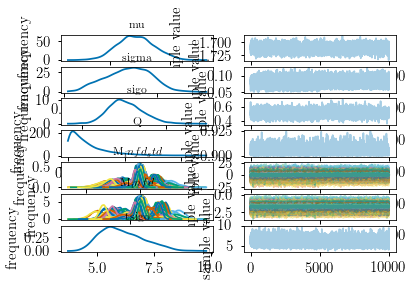

In [16]:
fit.plot()
plt.show()

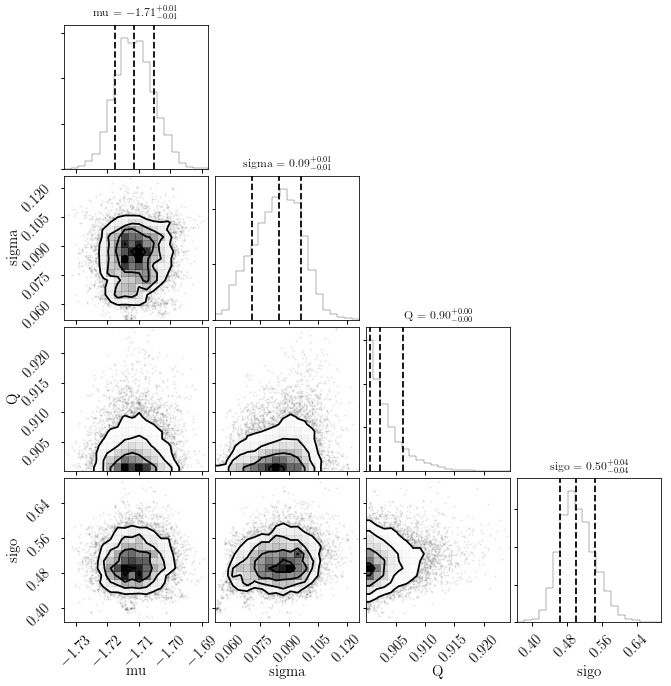

In [17]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']])#,fit['tmuo'],fit['sigo']])
corner.corner(chain.T,labels=['mu','sigma','Q','sigo'],#,'muo','sigo'],
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [18]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
muo = mu#np.median(fit['muo'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])
M_true = np.median(fit['M_infd'],axis=0)


fg = normal(M, mu, sigma)
bg = normal(M, mu, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

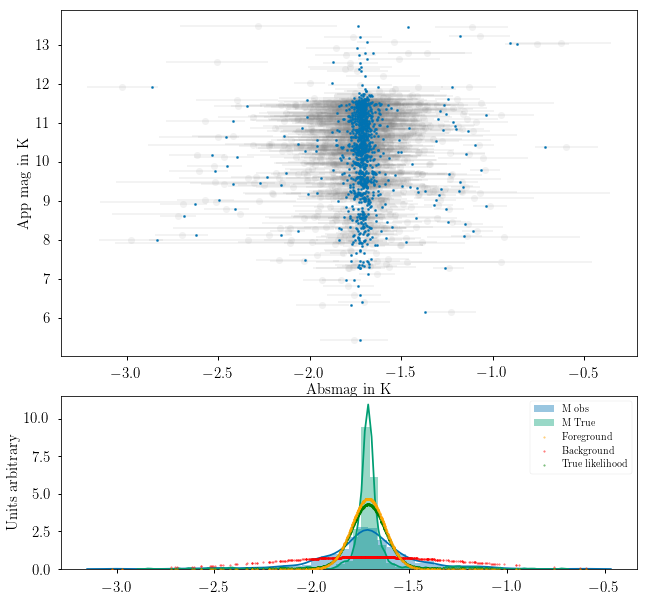

In [19]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])


sax.scatter(M_true,m,s=5,zorder=1000)
sax.errorbar(M,m,xerr=M_err,c='grey',fmt='o',alpha=.1,zorder=999)

sns.distplot(M, ax=xax, label='M obs')
sns.distplot(M_true,ax=xax, label='M True')
xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)
xax.legend()


sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [20]:
s = fit.summary()
print(fit)

Inference for Stan model: asterostan_d79aa939a205bdcd6531e89dfb78632e.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.71  2.7e-4 6.0e-3  -1.72  -1.72  -1.71  -1.71   -1.7  520.0    1.0
sigma             0.08  1.8e-3   0.01   0.06   0.08   0.09   0.09   0.11   43.0   1.04
sigo               0.5  1.5e-3   0.04   0.43   0.48    0.5   0.53   0.59  717.0    1.0
Q                  0.9  1.6e-4 3.3e-3    0.9    0.9    0.9    0.9   0.91  417.0    1.0
M_infd_std[0]     0.06    0.04    1.1   -2.1  -0.58   0.07   0.74   2.07  707.0    1.0
M_infd_std[1]    -0.46    0.03   0.95  -2.36  -1.08  -0.45   0.16   1.38 1166.0    1.0
M_infd_std[2]    -0.53    0.04   1.03  -2.64  -1.12  -0.48   0.12   1.32  629.0   1.01
M_infd_std[3]    -0.89    0.06   1.31  -4.73  -1.42  -0.76  -0.11    1.1  511.0    1.0
M_infd_std[4]     0.22    

[1.00365056 1.04149392 1.00181797 ... 1.0037853  1.03471224 1.03278064]
Total number of Rhats: 2006
Total number of Rhats with the NaN values removed: 2006


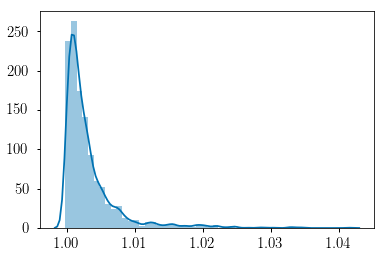

In [21]:
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [ ]:
sys.exit()

## Other useful code

In [ ]:
sns.distplot(Ks[heb])
plt.scatter(Ks,fg,s=3)
sns.distplot(Ks[~heb])
plt.scatter(Ks,bg,s=3)
plt.show()

sns.distplot(Ks)
plt.scatter(Ks,L,s=3)
plt.show()

In [ ]:
sys.exit()


In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
import barbershop
%pylab inline
barber = barbershop.open(df,'ast_MKs','M')
barber.add_client('stage')
barber.add_client('logg')
barber.add_client('M')
barber.histograms_on(x=True, y=True)
barber.show_mirror()

In [ ]:
list(df)
import os
os.path.isfile('../data/KepxDR2/MRCxyu18.csv')

In [ ]:
'''
generated quantities {
    vector[N] post_prob;
    vector[N] bg_pp;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(M_true_std[n] | 0, 1);
        ll_bg = log(1-Q) + normal_lpdf(M_true_std[n] | tmuo, tsigo);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_pp[n] = exp(ll_bg - log_sum_exp(ll_fg, ll_bg));
    }
}
'''

In [ ]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

# cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(M,m,s=5,c=post_prob,zorder=1000)
# fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(M,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(M,ax=xax)

xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)
mask = lnK > 1.

cheb_correct = len(M[mask][sel.stage[mask]==2])
cheb_total = len(M)
identified_total = len(M[mask])
recall = float(cheb_correct)/float(cheb_total)

print('Total stars: '+str(cheb_total))
print('Total IDd as inlier: '+str(cheb_correct))
print('Total rejected: '+str(cheb_total-cheb_correct))
print('This is a '+str((cheb_total-cheb_correct)*100./cheb_total)+'% rejection.')

In [ ]:
fig, (ax,ax2)  = plt.subplots(2,figsize=(10,10))
ax.scatter(M[~mask],m[~mask],s=5,c=post_prob[~mask],zorder=1000, label='Outliers')
fig.colorbar(c,ax=ax, label='Posterior Probability')
ax.errorbar(M[~mask],m[~mask],xerr=M_err[~mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax.scatter(M[mask],m[mask],s=1,alpha=.1,c='r', label='Inliers')
ax.legend()

ax2.scatter(M[mask],m[mask],s=5,c=post_prob[mask],zorder=1000, label='Inliers')
fig.colorbar(c, ax = ax2, label='Posterior Probability')
ax2.errorbar(M[mask],m[mask],xerr=M_err[mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax2.scatter(M[~mask],m[~mask],s=10,alpha=.5,c='r',label='Outliers')
ax2.legend()

ax.set_xlabel('Absmag in K')
ax.set_ylabel('App mag in K')
plt.show()

What the above plot indicates is that inlier stars are defined by uncertainty more than anything else, and that allt he outlier stars have uncertainties that end near a similar limit, whereas the inlier stars can be more spread out, so long as their uncertainties have a chance at placing them at the overdensity.